In [1]:

!pip install numpy==1.24.3 --force-reinstall

import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for numpy==1.24.3 from https://files.pythonhosted.org/packages/6f/72/38f9a536bdb5bfb1682f2520f133ec6e08dde8bcca1f632e347641d90763/numpy-1.24.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached numpy-1.24.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


2025-04-18 10:41:41.252783: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-18 10:41:41.890829: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# -------- CONFIG --------
IMG_SIZE = (400,800)
BATCH_SIZE = 8  # You can tune this based on your RAM/GPU
EPOCHS = 10

# -------- PATHS -------- (update for local paths)
train_csv = "train.csv"
val_csv = "valid.csv"
test_csv = "test.csv"

train_dir = "/home/rtg7bs/DATA/train"
val_dir = "/home/rtg7bs/DATA/valid"
test_dir = "/home/rtg7bs/DATA/test"

AUTOTUNE = tf.data.AUTOTUNE


# -------- READ DATAFRAME --------
def get_dataset_from_csv(csv_file, image_dir):
    df = pd.read_csv(csv_file)
    df['file_path'] = df['file_name'].apply(lambda x: os.path.join(image_dir, x))
    file_paths = df['file_path'].values
    labels = df['category_id'].values
    return file_paths, labels


# -------- PREPROCESS FUNCTION --------
def process_path(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label


# -------- BUILD TF.DATA PIPELINE --------
def build_dataset(file_paths, labels, is_training=True):
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)
    if is_training:
        ds = ds.shuffle(1000)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds


# -------- LOAD DATASETS --------
train_files, train_labels = get_dataset_from_csv(train_csv, train_dir)
val_files, val_labels = get_dataset_from_csv(val_csv, val_dir)
test_files, test_labels = get_dataset_from_csv(test_csv, test_dir)
print(set(train_labels))
num_classes = len(set(train_labels))
print(num_classes)

train_ds = build_dataset(train_files, train_labels, is_training=True)
val_ds = build_dataset(val_files, val_labels, is_training=False)
test_ds = build_dataset(test_files, test_labels, is_training=False)


{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
14


2025-04-18 10:41:48.876118: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [3]:
print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")
print(f"Test samples: {len(test_files)}")

Training samples: 1535
Validation samples: 435
Test samples: 204


In [4]:
# Check a batch from the training dataset
for images, labels in train_ds.take(1):  # This will take just 1 batch
    print(f"Batch shape: {images.shape}")  # Should be (BATCH_SIZE, IMG_SIZE[0], IMG_SIZE[1], 3)
    print(f"Labels: {labels.shape}")  # Should be a batch of labels (BATCH_SIZE,)
    
# Check a batch from the validation dataset
for images, labels in val_ds.take(1):
    print(f"Batch shape: {images.shape}")
    print(f"Labels: {labels.shape}")

# Check a batch from the test dataset
for images, labels in test_ds.take(1):
    print(f"Batch shape: {images.shape}")
    print(f"Labels: {labels.shape}")


2025-04-18 10:42:03.059189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 359 of 1000
2025-04-18 10:42:13.065944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 715 of 1000
2025-04-18 10:42:21.171961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Batch shape: (8, 400, 800, 3)
Labels: (8,)
Batch shape: (8, 400, 800, 3)
Labels: (8,)
Batch shape: (8, 400, 800, 3)
Labels: (8,)


2025-04-18 10:42:41.608532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 375 of 1000
2025-04-18 10:42:51.605840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 753 of 1000
2025-04-18 10:42:58.233683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


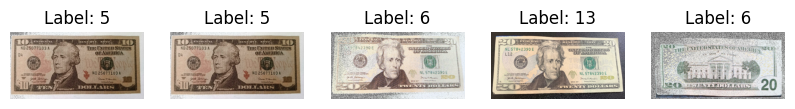

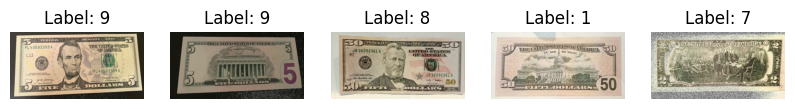

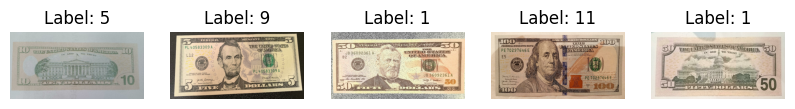

In [5]:
def visualize_samples(dataset, num_samples=5):
    plt.figure(figsize=(10, 10))
    for i, (images, labels) in enumerate(dataset.take(1)):  # Only take the first batch
        for j in range(min(num_samples, BATCH_SIZE)):
            plt.subplot(1, num_samples, j + 1)
            plt.imshow(images[j])  # Display the image
            plt.title(f"Label: {labels[j].numpy()}")
            plt.axis("off")
    plt.show()

# Visualize some images from the training set
visualize_samples(train_ds)

# Visualize some images from the validation set
visualize_samples(val_ds)

# Visualize some images from the test set
visualize_samples(test_ds)


In [6]:
# Check the shape of the first batch
for images, labels in train_ds.take(1):
    print(f"Image batch shape: {images.shape}")  # Should be (BATCH_SIZE, 1600, 3200, 3)
    print(f"Labels batch shape: {labels.shape}")  # Should be (BATCH_SIZE,)


2025-04-18 10:43:24.265403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 374 of 1000
2025-04-18 10:43:34.294234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 752 of 1000
2025-04-18 10:43:40.953194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Image batch shape: (8, 400, 800, 3)
Labels batch shape: (8,)


In [7]:
# -------- BUILD MODEL -------- (change the layers!)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

def adjust_labels(image, label):
    # Shift labels from 1-indexed (1 to 14) to 0-indexed (0 to 13)
    label = label - 1  # Adjust the label
    return image, label

# Apply this adjustment to your datasets
train_ds = train_ds.map(adjust_labels)  # Apply the adjustment to training dataset
val_ds = val_ds.map(adjust_labels)      # Apply to validation dataset (if necessary)
test_ds = test_ds.map(adjust_labels)    # Apply to test dataset (if necessary)


# -------- TRAIN --------
model.fit(train_ds,
          validation_data=val_ds,
          epochs=EPOCHS)

# -------- EVALUATE --------
loss, acc = model.evaluate(test_ds)
print(f"\n✅ Test accuracy: {acc:.4f}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 398, 798, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 199, 399, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 397, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 98, 198, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 196, 64)       18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 48, 98, 64)        0

2025-04-18 10:44:53.873407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 372 of 1000
2025-04-18 10:45:03.911600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 748 of 1000
2025-04-18 10:45:10.806394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


192/192 [==============================] - 226s 1s/step - loss: 1.0564 - accuracy: 0.7726 - val_loss: 1.5060e-04 - val_accuracy: 1.0000
Epoch 2/10


2025-04-18 10:48:39.527834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 377 of 1000
2025-04-18 10:48:49.546175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 757 of 1000
2025-04-18 10:48:56.013219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


192/192 [==============================] - 225s 1s/step - loss: 0.0402 - accuracy: 0.9870 - val_loss: 2.5866e-05 - val_accuracy: 1.0000
Epoch 3/10


2025-04-18 10:52:24.658313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 305 of 1000
2025-04-18 10:52:34.661083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 620 of 1000
2025-04-18 10:52:44.660283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 928 of 1000
2025-04-18 10:52:47.125274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


192/192 [==============================] - 230s 1s/step - loss: 0.0270 - accuracy: 0.9928 - val_loss: 2.2789e-05 - val_accuracy: 1.0000
Epoch 4/10


2025-04-18 10:56:14.947271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 365 of 1000
2025-04-18 10:56:24.941542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 734 of 1000
2025-04-18 10:56:32.195244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


192/192 [==============================] - 224s 1s/step - loss: 0.0148 - accuracy: 0.9961 - val_loss: 3.1887e-06 - val_accuracy: 1.0000
Epoch 5/10


2025-04-18 10:59:59.324225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 368 of 1000
2025-04-18 11:00:09.320088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 735 of 1000
2025-04-18 11:00:16.510898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


192/192 [==============================] - 224s 1s/step - loss: 0.0163 - accuracy: 0.9948 - val_loss: 1.7840e-07 - val_accuracy: 1.0000
Epoch 6/10


2025-04-18 11:03:43.620295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 370 of 1000
2025-04-18 11:03:53.615483: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 744 of 1000
2025-04-18 11:04:00.524053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


192/192 [==============================] - 224s 1s/step - loss: 0.0085 - accuracy: 0.9967 - val_loss: 7.0429e-06 - val_accuracy: 1.0000
Epoch 7/10


2025-04-18 11:07:27.959165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 373 of 1000
2025-04-18 11:07:37.956628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 750 of 1000
2025-04-18 11:07:44.632036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


192/192 [==============================] - 224s 1s/step - loss: 0.0051 - accuracy: 0.9980 - val_loss: 6.2565e-06 - val_accuracy: 1.0000
Epoch 8/10


2025-04-18 11:11:11.577248: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 371 of 1000
2025-04-18 11:11:21.576990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 748 of 1000
2025-04-18 11:11:28.358884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


192/192 [==============================] - 224s 1s/step - loss: 0.0112 - accuracy: 0.9987 - val_loss: 2.2512e-06 - val_accuracy: 1.0000
Epoch 9/10


2025-04-18 11:14:55.459726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 372 of 1000
2025-04-18 11:15:05.452748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 742 of 1000
2025-04-18 11:15:12.354702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


192/192 [==============================] - 225s 1s/step - loss: 0.0101 - accuracy: 0.9980 - val_loss: 5.9742e-08 - val_accuracy: 1.0000
Epoch 10/10


2025-04-18 11:18:40.144757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 369 of 1000
2025-04-18 11:18:50.162759: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 743 of 1000
2025-04-18 11:18:57.064969: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


26/26 [==============================] - 12s 477ms/step - loss: 1.3112e-05 - accuracy: 1.0000

✅ Test accuracy: 1.0000


In [10]:
import numpy as np
from sklearn.metrics import f1_score
# Get the true labels from the test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Get the predicted labels for the test dataset
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=-1)  # For multi-class classification

# Calculate the F1-score
f1 = f1_score(y_true, y_pred_classes, average='weighted')  # 'weighted' is typically used for multi-class
print(f"✅ F1-score: {f1:.4f}")

26/26 [==============================] - 9s 332ms/step
✅ F1-score: 1.0000


1/1 [==============================] - 0s 100ms/step


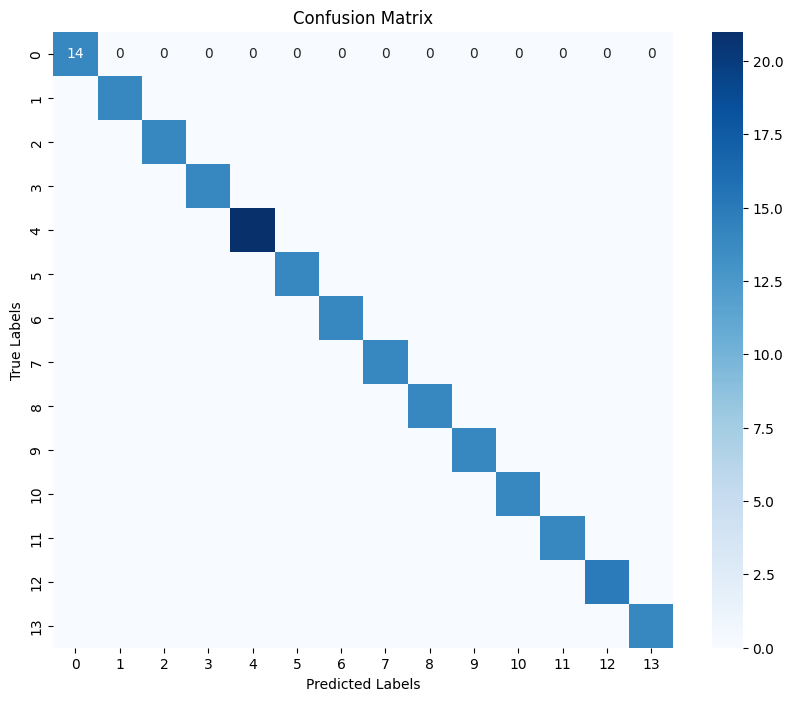

In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the true labels for the test set (you can use `test_ds` or `val_ds` depending on which set you want to evaluate)
y_true = []
y_pred = []

# Loop through the test dataset and get the true labels and predictions
for image, label in test_ds:
    y_true.extend(label.numpy())  # True labels
    y_pred.extend(np.argmax(model.predict(image), axis=-1))  # Predicted labels

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
